## Objectives:
Step two of lake_wildfire_productivity project. 

This isn't necessary for analysis output, rather a script to make general observations about the trends of the tabular data provided from the MTBS and the LimnoSat tabular data. This is intended to be interactive. Figures can be adjusted by changing parameters of the plot subset cells above plot building cells.  

## 1. Import needed packages and set working directory

In [1]:
import os
import os.path as op

import earthpy as et
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import seaborn as sns

import ee
import geemap

# Check the version
print(pd.__version__)
print(gpd.__version__)

# Initialize Google Earth Engine to generate area of interest and deep_point data

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

1.2.4
0.9.0


# 2. Set working directory

In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'cu_earthdata_certificate_2021', 'earthlab_project', 'data')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


## 3. Checking LimnoSat's area of color estimation 
LimnoSat provides the median band values of only high confidence water pixels within 120 meters of the
deepest point.

What does this really look like? 

Merely generating a buffer around a point that has been converted to an ee.object will show the point in the wrong projection in folium (used in geemap).  To show the points as they are projected in google earth engine, converting a shapefile with buffers already in place to an ee.object with geemap.shp_to_ee works better. 
Here we use the deep point of Seaman Reservior in Northern Colorado to approximate where the color values 
are derived from (each of the next 3 chunks will take a few minutes to run):

In [3]:
# Bring in deep points dataset with just the 120m buffer exported in 01_download...
filepath = os.path.join('hydro_color.shp') # This file will provide a 120m lake point buffer. 
# When observing lake points, consider that not all points here are included in the 
# evaluated dataset
dp = geemap.shp_to_ee(filepath)

In [4]:
# Bring in the sampled dataset
filepath2 = os.path.join('landsat_n_burnpolys.shp') #this is the acutal sampled dataset, doesn't contain
# color 
burned_df = geemap.shp_to_ee(filepath2)

In [5]:
# # Apply dataset to map

latitude = 40.706961
longitude = -105.235506 #zoom in on example point

# # Load a Landsat image for lake of interest
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_034032_20180814')

Map = geemap.Map(center=[latitude,longitude], zoom=14)
Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 200, 'max': 400}, 'example_img_seaman_res')
Map.addLayer(dp, {}, 'LimnoSat color derivation buffer')
Map.addLayer(burned_df, {}, 'sampled points')

Map

KeyboardInterrupt: 

## 4. Import in tabular dataset 
Produced in the last step of 01_download_clip_merge, the merged dataset matches tabular data from MTBS and LimnoSat datasets based on overlappling lake and fire polygons

In [6]:
# Indicate path to site directories
mtbs_path = os.path.join("lake_mtbs_merged_tab.csv")

if os.path.exists(mtbs_path):
    burned_lakes_tabular = pd.read_csv(mtbs_path, low_memory=False)

else:
    print(".csv not found, make sure that '01_download_clip_merge' notebook has been successfully run")

## 5. Add classifications 
to the dataframe based on Landsat image date and fire ignition date

Identify Landsat imagery as pre- or post fire and add classification to new column

In [7]:
# Check date structure of ignition date (Ig_Date) and image date (date)
# colo_tabular.info()

# Both are objects after import, convert to dates
burned_lakes_tabular['date'] = pd.to_datetime(burned_lakes_tabular['date'])
burned_lakes_tabular['Ig_Date'] = pd.to_datetime(burned_lakes_tabular['Ig_Date'])

In [8]:
# Generate pre or post fire classification of Landsat imagery based on condition
# that image date is before ingition date
burned_lakes_tabular['pre_post'] = np.where(
    burned_lakes_tabular['date'] < burned_lakes_tabular['Ig_Date'], "pre-fire", "post-fire")
# print(burned_lakes_tabular.pre_post)

# Generate a calculation for the lapse of time pre- or post fire for plotting
burned_lakes_tabular['days_since'] = (burned_lakes_tabular['date'] - burned_lakes_tabular['Ig_Date'])

# Convert days_since to numerical/integer value that can be plotted
burned_lakes_tabular.days_since = burned_lakes_tabular.days_since.astype(
    'timedelta64[D]').astype(int)
# print(burned_lakes_tabular.days_since)

# Add a image month column for trend monitoring
burned_lakes_tabular['img_month'] = pd.DatetimeIndex(burned_lakes_tabular['date']).month

# Add a classification that identifies the number of years since the fire.
# This method allows for manual adjustment of year assingment
col = burned_lakes_tabular['days_since']
conditions = [(col < 2920) & (col >= 2555),
              (col < 2555) & (col >= 2190),
              (col < 2190) & (col >= 1825),
              (col < 1825) & (col >= 1460),
              (col < 1460) & (col >= 1095),
              (col < 1095) & (col >= 730),
              (col < 730) & (col >= 365),
              (col >= 0) & (col < 365),
              (col < 0) & (col >= -365),
              (col < -365) & (col >= -730),
              (col < -703) & (col >= -1095),
              (col < -1095) & (col >= -1460),
              (col < -1460) & (col >= -1825),
              (col < -1825) | (col >= -2190),
              (col < -2190) | (col >= -2555),
              (col < -2555) | (col >= -2920)]
choices = ['8', '7', '6', '5', '4', '3', '2', '1',
           '0', '-1', '-2', '-3', '-4', '-5', '-6', '-7']
burned_lakes_tabular['years_since'] = np.select(conditions, choices, default='meh')
burned_lakes_tabular['years_since'] = burned_lakes_tabular['years_since'].astype(int)

In [9]:
#GET RID OF IF MAP WORKS

# latitude = 40.706961
# longitude = -105.235506

# # Make lat. and long. vars an `ee.Geometry.Point`.
# point = ee.Geometry.Point([longitude, latitude])#.reproject('EPSG:4326') 

# # # Apply the buffer method to the Point object.
# # pointBuffer = point.buffer(120);

# # # Apply the buffer method to the Point object.
# # catchmentBuffer = point.buffer(2000);

# # # Load a Landsat image.
# # img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_034032_20180814')

# # Map = geemap.Map(center=[latitude,longitude], zoom=14)
# # Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 200, 'max': 400}, 'example_img_seaman_res')
# # Map.addLayer(point, {}, 'chebysev point')
# # Map.addLayer(pointBuffer, {}, 'LimnoSat color derivation buffer')
# # Map.addLayer(catchmentBuffer, {}, 'catchment buffer')
# # Map

## 6. Plots

### 6a. The following plot will visualize Landsat band values in response to days since fire

Subset data to desire time period

In [10]:
# When exploring data, can subset by month to limit seasonal effects
plot_subset = burned_lakes_tabular.loc[burned_lakes_tabular['img_month'] == 7]

plot_subset = plot_subset.loc[(plot_subset['days_since'] < 2920) & (plot_subset['days_since'] > -2920)]

#plot_subset.dtypes

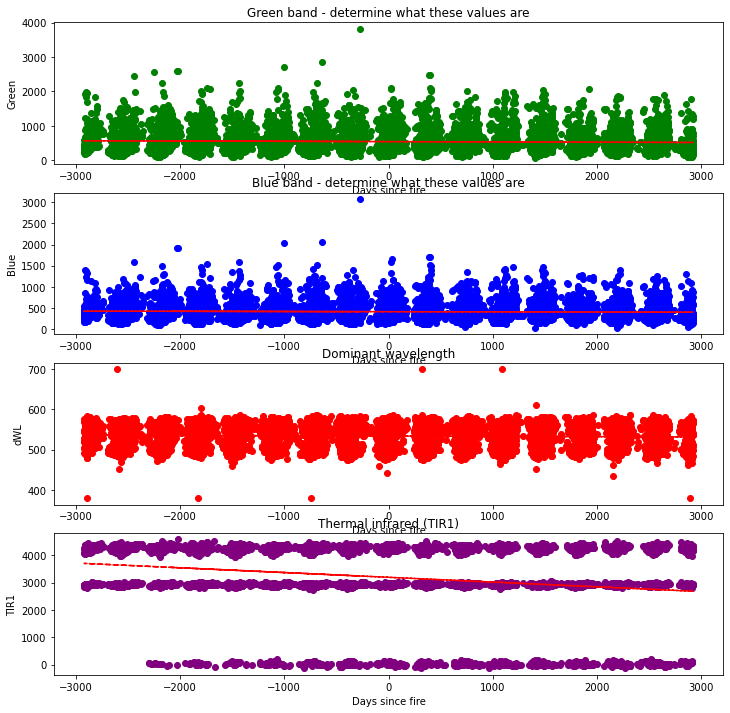

In [11]:
# Plots
# Plot 1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

ax1.scatter(x=plot_subset['days_since'],
            y=plot_subset['Green'],
            color='green')
ax1.set(title="Green band - determine what these values are",
        xlabel="Days since fire",
        ylabel="Green")

# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['Green'], 1)
p = np.poly1d(z)
ax1.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")


# Plot 2
ax2.scatter(x=plot_subset['days_since'],
            y=plot_subset['Blue'],
            color='blue')
ax2.set(title="Blue band - determine what these values are",
        xlabel="Days since fire",
        ylabel="Blue")

# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['Blue'], 1)
p = np.poly1d(z)
ax2.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

# Plot 3
ax3.scatter(x=plot_subset['days_since'],
            y=plot_subset['dWL'],
            color='red')
ax3.set(title="Dominant wavelength",
        xlabel="Days since fire",
        ylabel="dWL")

# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['dWL'], 1)
p = np.poly1d(z)
ax3.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

# Plot 4
ax4.scatter(x=plot_subset['days_since'],
            y=plot_subset['TIR1'],
            color='purple')
ax4.set(title="Thermal infrared (TIR1)",
        xlabel="Days since fire",
        ylabel="TIR1")

# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['TIR1'], 1)
p = np.poly1d(z)
ax4.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

### Estimation of Lake Color
The dWL column in the LandSat dataset provides a calculated dominant wavelength that is used to assign Forel Ule index values.
Topp's quatification of "lake color as the dominant wavelength within the human visible spectrum by transformaing surface reflectance into the chromaticity colorspace (Wang et al. 2015). Tristimulus values were calculated from surface reflectance values":
X = 2.7689(red) + 1.7517(green) + 1.11302(blue)
Y = 1(red) + 4.5907(green) + 0.0601(blue)
Z = 0.0565(green) + 5.5943(blue)

x = X/X+Y+Z   y = Y/X+Y+Z    z = Z/X+Y+Z

Using these coordinates, the hue angle is calculated with (arctan2(x-0.33/y-0.33)(180/pi)
This is converted to dominant wavelength from (dWL)

This can be transformed to the FUI index (check out Limnosat tutorial for more): https://github.com/SimonTopp/Walkthroughs/blob/main/LimnoSat_US_Tutorial.Rmd)

In [12]:
# add forel ule index to dWL for visualization
col = burned_lakes_tabular['dWL']
conditions = [(col == 583) & (col > 581),
              (col <= 581) & (col > 579),
              (col <= 579) & (col > 577),
              (col <= 577) & (col > 575),
              (col <= 575) & (col > 573),
              (col <= 573) & (col > 571),
              (col <= 571) & (col > 570),
              (col <= 570) & (col > 569),
              (col <= 569) & (col > 568),
              (col <= 568) & (col > 567),
              (col <= 567) & (col > 564),
              (col <= 564) & (col > 559),
              (col <= 559) & (col > 549),
              (col <= 549) & (col > 530),
              (col <= 530) & (col > 509),
              (col <= 509) & (col > 495),
              (col <= 495) & (col > 489),
              (col <= 489) & (col > 485),
              (col <= 485) & (col > 480),
              (col <= 480) & (col > 475),
              (col > 470) & (col <= 475)]


choices = ['21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11',
           '10', '9', '8', '7', '6', '5', '4', '3', '2', '1']
burned_lakes_tabular['fui'] = np.select(conditions, choices, default='1001')
burned_lakes_tabular['fui'] = pd.to_numeric(burned_lakes_tabular['fui'], errors='coerce')

choices = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
           'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
burned_lakes_tabular['fui_color'] = np.select(conditions, choices, default='v')

# Check that new or converted values make sense
burned_lakes_tabular[['Ig_Date', 'date', 'pre_post',
              'days_since', 'img_month', 'years_since', 'dWL', 'fui']].head

# burned_lakes_tabular.dtypes

<bound method NDFrame.head of           Ig_Date       date   pre_post  days_since  img_month  years_since  \
0      2011-04-07 1999-07-12   pre-fire       -4287          7           -5   
1      2011-04-07 1999-07-28   pre-fire       -4271          7           -5   
2      2011-04-07 1999-08-13   pre-fire       -4255          8           -5   
3      2011-04-07 1999-09-14   pre-fire       -4223          9           -5   
4      2011-04-07 1999-09-30   pre-fire       -4207          9           -5   
...           ...        ...        ...         ...        ...          ...   
165342 2019-10-01 2010-04-25   pre-fire       -3446          4           -5   
165343 1988-07-22 1996-06-10  post-fire        2880          6            8   
165344 2012-08-10 1996-06-10   pre-fire       -5905          6           -5   
165345 1988-07-22 1998-05-31  post-fire        3600          5           -5   
165346 2012-08-10 1998-05-31   pre-fire       -5185          5           -5   

          dWL   fui  

In [13]:
# Create a dictionary where you assign each attribute value to a particular color for plotting
fui_colors = {'a':  "#2158bc", 'b': "#316dc5", 'c': "#327cbb", 'd': "#4b80a0", 'e': "#568f96", 'f': "#6d9298",
              'g': "#698c86", 'h': "#759e72", 'i': "#7ba654", 'j': "#7dae38", 'k': "#94b660",
              'l': "#94b660", 'm': "#a5bc76", 'n': "#aab86d", 'o': "#adb55f", 'p': "#a8a965",
              'q': "#ae9f5c", 'r': "#b3a053", 's': "#af8a44", 't': "#a46905", 'u': "#9f4d04", 'v': "#9E250C"}

In [14]:
# Create directory to store new image for blog
images_dir_path = op.join(op.dirname(op.abspath('')), 'ea-2021-final-project-wildfire_lake_productivity', 'images')

# Check that is exists, and if it doesn't, create it
if not op.isdir(images_dir_path):
    os.mkdir(images_dir_path)

In [15]:
# Summer observations over timem (where time is relative to fire ignition date)

plot_subset = burned_lakes_tabular.loc[(burned_lakes_tabular['img_month'] == 7)
                               | (burned_lakes_tabular['img_month'] == 8)]

plot_subset = plot_subset.loc[(plot_subset['years_since'] < 8) & (
    plot_subset['years_since'] > -5) & (plot_subset['fui'] != 1001)]

# The years represented in plots may not be evident, add min and max years to plot titles
# CAN ADD THIS TO PLOT TITLE FUNCTION TO PRINT AUTOMATICALLY
max_yr = plot_subset['date'].max()
min_yr = plot_subset['date'].min()
max_lapse = plot_subset['years_since'].max()
print(max_yr)
print(min_yr)
print(max_lapse)

# plot_subset.dtypes

2019-08-31 00:00:00
1984-07-04 00:00:00
7


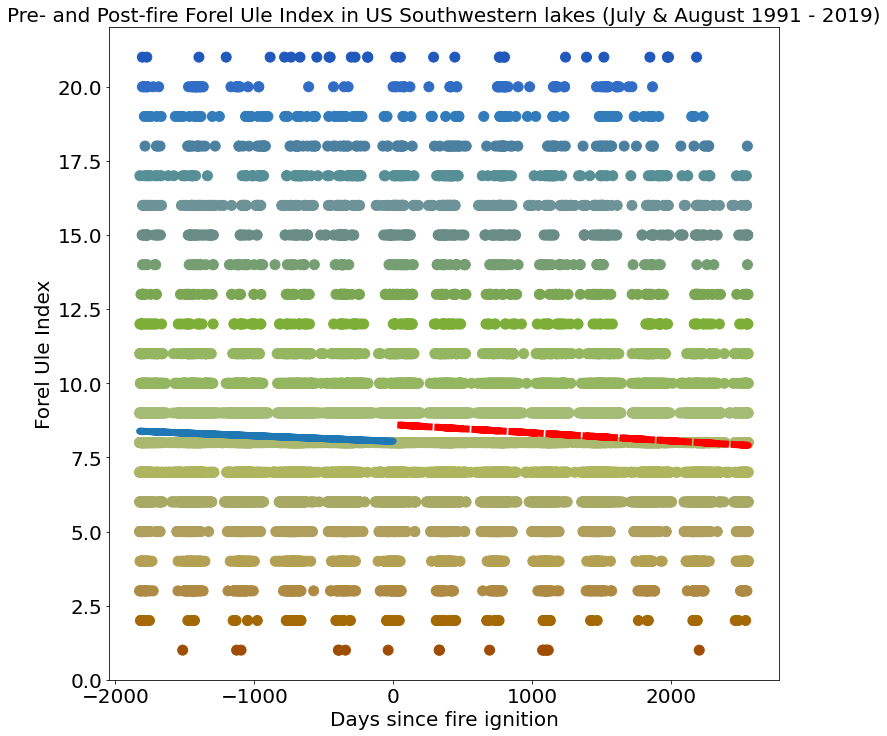

In [16]:
# plot fui trends:
# Plots

fig, (ax) = plt.subplots(figsize=(12, 12))

ax.scatter(x=plot_subset['days_since'],
           y=plot_subset['fui'],
           c=plot_subset['fui_color'].apply(lambda x: fui_colors[x]),
           s=100)


# calc the trendlines
pre_fire = plot_subset.loc[(plot_subset['days_since'] < 0)]
post_fire = plot_subset.loc[(plot_subset['days_since'] >= 0)]

z = np.polyfit(pre_fire['days_since'], pre_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(pre_fire['days_since'], p(pre_fire['days_since']), linewidth=7.0)

z = np.polyfit(post_fire['days_since'], post_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(post_fire['days_since'], p(
    post_fire['days_since']), "r--", linewidth=7.0)

ax.set(title='Pre- and Post-fire Forel Ule Index in US Southwestern lakes (July & August 1991 - 2019)',
       xlabel='Days since fire ignition',
       ylabel='Forel Ule Index')

ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

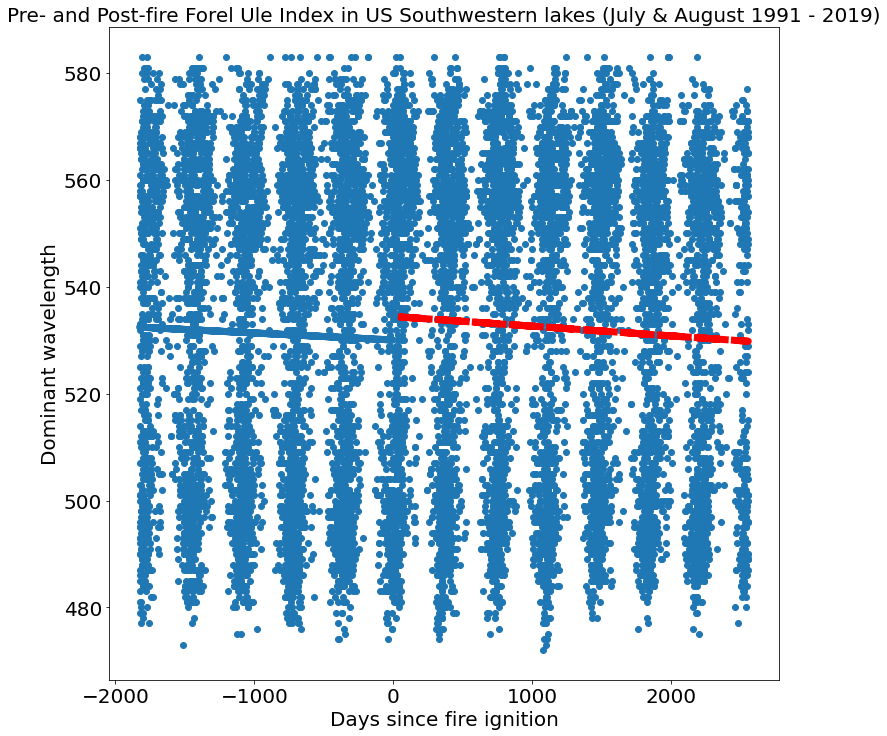

In [17]:
# plot dominant wavelength trends:
# Plots

fig, (ax) = plt.subplots(figsize=(12, 12))

ax.scatter(x=plot_subset['days_since'],
           y=plot_subset['dWL'])


# calc the trendlines
pre_fire = plot_subset.loc[(plot_subset['days_since'] < 0)]
post_fire = plot_subset.loc[(plot_subset['days_since'] >= 0)]

z = np.polyfit(pre_fire['days_since'], pre_fire['dWL'], 1)
p = np.poly1d(z)
ax.plot(pre_fire['days_since'], p(pre_fire['days_since']), linewidth=7.0)

z = np.polyfit(post_fire['days_since'], post_fire['dWL'], 1)
p = np.poly1d(z)
ax.plot(post_fire['days_since'], p(
    post_fire['days_since']), "r--", linewidth=7.0)

ax.set(title='Pre- and Post-fire Forel Ule Index in US Southwestern lakes (July & August 1991 - 2019)',
       xlabel='Days since fire ignition',
       ylabel='Dominant wavelength')

ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

### Distribution by month or season
in response to years since fire

Text(0.5, 1.0, 'August')

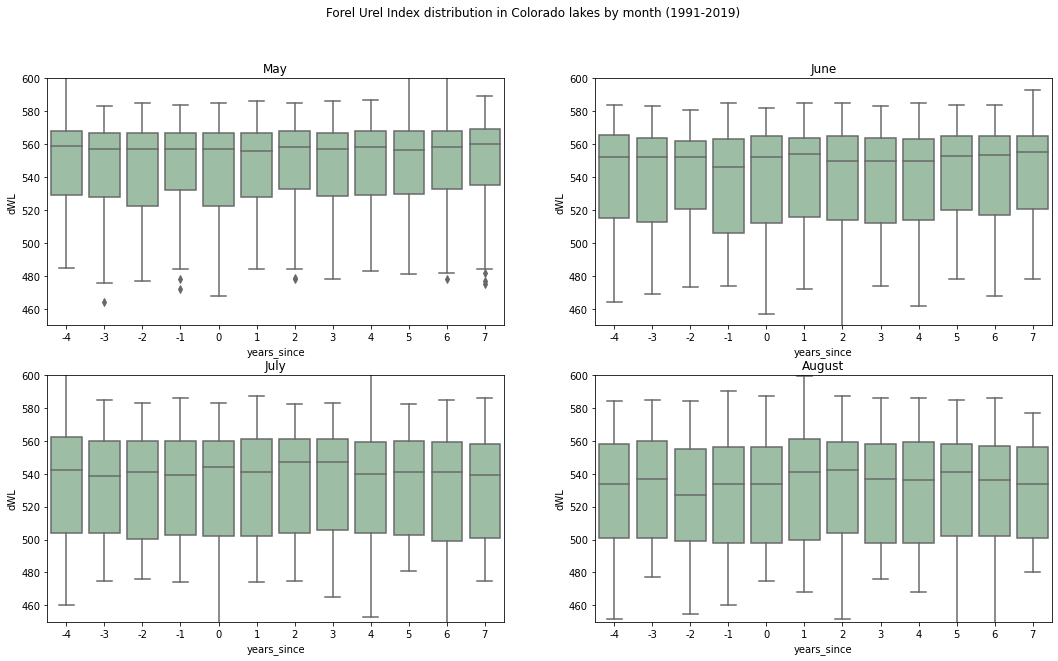

In [18]:
plot_subset = burned_lakes_tabular.loc[(burned_lakes_tabular['years_since'] < 8) & (
    burned_lakes_tabular['years_since'] > -5)]

# subset by month
may = plot_subset.loc[(plot_subset['img_month'] == 5)]
june = plot_subset.loc[(plot_subset['img_month'] == 6)]
july = plot_subset.loc[(plot_subset['img_month'] == 7)]
aug = plot_subset.loc[(plot_subset['img_month'] == 8)]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle(
    'Forel Urel Index distribution in Colorado lakes by month (1991-2019)')

sns.boxplot(ax=axes[0, 0], data=may, 
            x='years_since', 
            y='dWL', 
            color='#99c2a2')
axes[0, 0].set_ylim([450, 600])
axes[0, 0].set_title("May")
# sns.swarmplot(ax=axes[0, 0], data=may, x='years_since', y='fui',color='#7d0013' )
sns.boxplot(ax=axes[0, 1], data=june,
            x='years_since', 
            y='dWL', 
            color='#99c2a2')
axes[0, 1].set_ylim([450, 600])
axes[0, 1].set_title("June")
sns.boxplot(ax=axes[1, 0], 
            data=july,
            x='years_since', 
            y='dWL', 
            color='#99c2a2')
axes[1, 0].set_ylim([450, 600])
axes[1, 0].set_title("July")

sns.boxplot(ax=axes[1, 1], 
            data=aug, 
            x='years_since', 
            y='dWL', 
            color='#99c2a2')
axes[1, 1].set_ylim([450, 600])
axes[1, 1].set_title("August")

### Trends and image color distributions of individual lakes
Boxplots

# Add a function to reduce the lines needed to adjust labeling

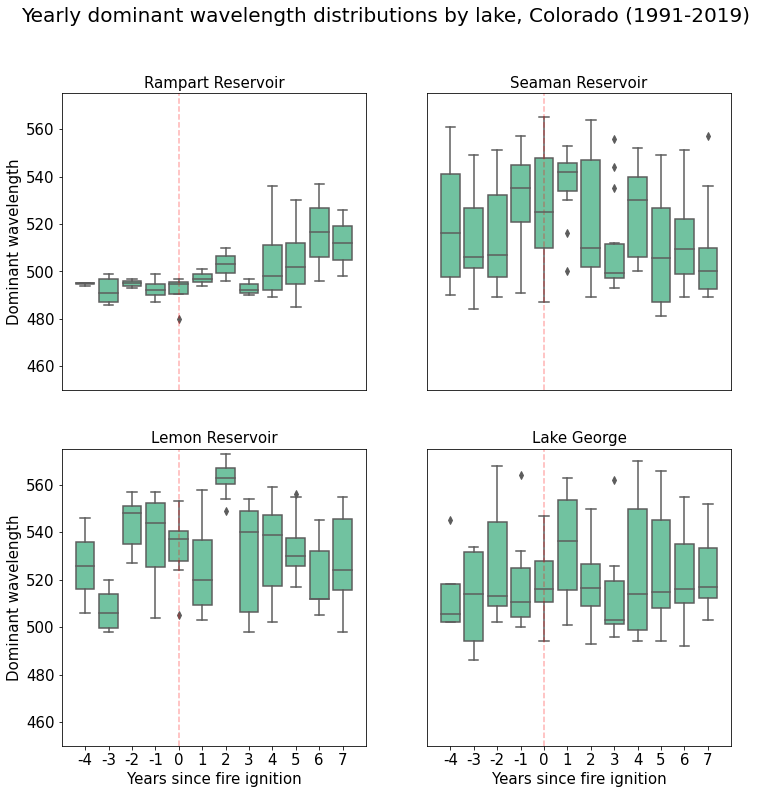

In [19]:
plot_subset = burned_lakes_tabular.loc[(burned_lakes_tabular['years_since'] < 8) & (
    burned_lakes_tabular['years_since'] > -5) & (burned_lakes_tabular['dWL'] != 1001)]
plot_subset = plot_subset.loc[(burned_lakes_tabular['img_month'] == 7)
                              | (burned_lakes_tabular['img_month'] == 8)]


# subset by month
waldo = plot_subset.loc[(plot_subset['Hylak_id'] == 112400)]
seaman = plot_subset.loc[(plot_subset['Hylak_id'] == 1055287)]
george = plot_subset.loc[(plot_subset['Hylak_id'] == 1057228)]
missionary = plot_subset.loc[(plot_subset['Hylak_id'] == 112664)]
spring = plot_subset.loc[(plot_subset['Hylak_id'] == 1056666)]
forbes = plot_subset.loc[(plot_subset['Hylak_id'] == 1058951)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]
silver = plot_subset.loc[(plot_subset['Hylak_id'] == 1055734)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle(
    'Yearly dominant wavelength distributions by lake, Colorado (1991-2019)', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=waldo,
            x='years_since', y='dWL', color='#64CFA2')
axes[0, 0].axvline(x=4, ymin=0.0, ymax=1.0, color='red', linestyle='--', alpha=0.3)
axes[0, 0].set_title("Rampart Reservoir")
axes[0, 0].set_xlim([-1, 12])
axes[0, 0].set_ylim([450, 575])
axes[0, 0].set_xticks([])
axes[0, 0].set_xlabel('')
axes[0, 0].yaxis.label.set_fontsize(15)
axes[0, 0].xaxis.label.set_fontsize(15)
axes[0, 0].title.set_fontsize(15)
axes[0, 0].tick_params(axis="x", labelsize=15)
axes[0, 0].tick_params(axis="y", labelsize=15)
axes[0, 0].set_ylabel('Dominant wavelength')
# sns.swarmplot(ax=axes[0, 0], data=waldo, x='years_since', y='fui',color='#7d0013' )


sns.boxplot(ax=axes[0, 1], data=seaman,
            x='years_since', y='dWL', color='#64CFA2')
axes[0, 1].set_title("Seaman Reservoir")
axes[0, 1].axvline(x=4, ymin=0.0, ymax=1.0, color='red', linestyle='--', alpha=0.3)
axes[0, 1].set_xlim([-1, 12])
axes[0, 1].set_ylim([450, 575])
axes[0, 1].set_yticks([])
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks([])
axes[0, 1].set_xlabel('')
axes[0, 1].yaxis.label.set_fontsize(15)
axes[0, 1].xaxis.label.set_fontsize(15)
axes[0, 1].title.set_fontsize(15)
axes[0, 1].tick_params(axis="x", labelsize=15)
axes[0, 1].tick_params(axis="y", labelsize=15)

sns.boxplot(ax=axes[1, 0], data=missionary,
            x='years_since', y='dWL', color='#64CFA2')
axes[1, 0].set_title("Lemon Reservoir")
axes[1, 0].axvline(x=4, ymin=0.0, ymax=1.0, color='red', linestyle='--', alpha=0.3)
axes[1, 0].set_xlim([-1, 12])
axes[1, 0].set_ylim([450, 575])
axes[1, 0].yaxis.label.set_fontsize(15)
axes[1, 0].xaxis.label.set_fontsize(15)
axes[1, 0].title.set_fontsize(15)
axes[1, 0].tick_params(axis="x", labelsize=15)
axes[1, 0].tick_params(axis="y", labelsize=15)
axes[1, 0].set_xlabel('Years since fire ignition')
axes[1, 0].set_ylabel('Dominant wavelength')

sns.boxplot(ax=axes[1, 1], data=george,
            x='years_since', y='dWL', color='#64CFA2')
axes[1, 1].set_title("Lake George")
axes[1, 1].axvline(x=4, ymin=0.0, ymax=1.0, color='red', linestyle='--', alpha=0.3)
axes[1, 1].set_xlim([-1, 12])
axes[1, 1].set_ylim([450, 575])
axes[1, 1].set_yticks([])
axes[1, 1].set_ylabel('')
axes[1, 1].yaxis.label.set_fontsize(15)
axes[1, 1].xaxis.label.set_fontsize(15)
axes[1, 1].title.set_fontsize(15)
axes[1, 1].tick_params(axis="x", labelsize=15)
axes[1, 1].tick_params(axis="y", labelsize=15)
axes[1, 1].set_xlabel('Years since fire ignition');

In [20]:
# Save the image to the images directory for use in blog
fig.savefig(op.join(images_dir_path, 'color_distribution.png'),
            bbox_inches='tight', dpi=150)

/Users/laurenkremer/miniconda3/envs/wildfire-lake-productivity/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='days_since', ylabel='fui'>

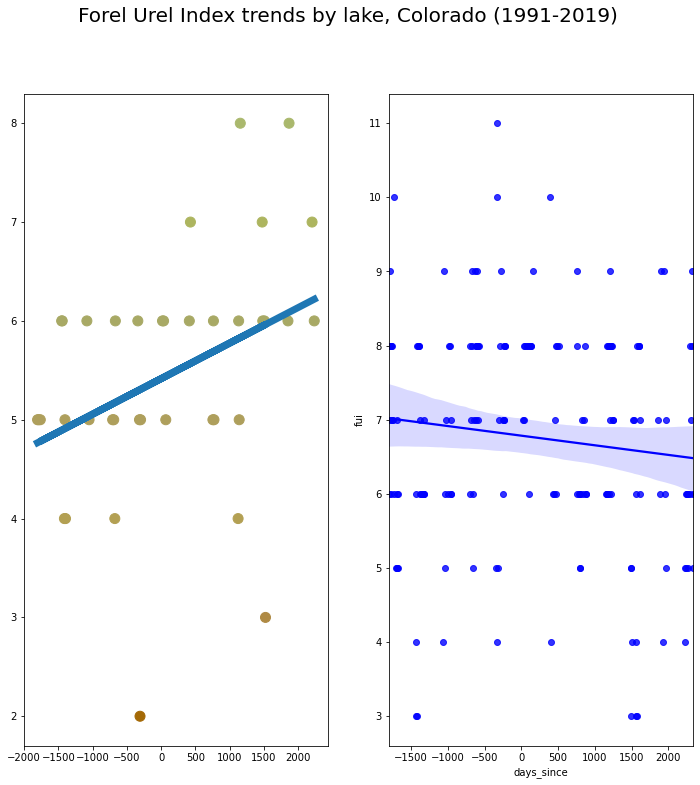

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

fig.suptitle(
    'Forel Urel Index trends by lake, Colorado (1991-2019)', fontsize=20)

# Plot 1
# subset
site_plot = waldo
ax1.scatter(x=site_plot['days_since'],
            y=site_plot['fui'],
            c=site_plot['fui_color'].apply(lambda x: fui_colors[x]),
            s=100)

# calc the trendlines
pre_fire = site_plot.loc[(site_plot['days_since'] < 0)]
post_fire = site_plot.loc[(site_plot['days_since'] >= 0)]

z = np.polyfit(site_plot['days_since'], site_plot['fui'], 1)
p = np.poly1d(z)
ax1.plot(site_plot['days_since'], p(site_plot['days_since']), linewidth=7.0)

# Plot 2  # without color catagorization
site_plot = seaman
sns.regplot(site_plot['days_since'],y=site_plot['fui'], color ='blue')


## 7. Export the csv so that months and time since fire can be used in randomforest analysis.

In [ ]:
# Export file to local drive
out_path = os.path.join("burned_lakes_tabular.csv")
burned_lakes_tabular.to_csv(out_path)